# Imports

In [28]:
from MLP import MLP
from MLP.loss import MSE, CROSSENTROPY
from MLP.activation import Activation
from MLP.initialization import WeightInitialization
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Experiment functions definition

In [29]:
def testdata_MLP_regression(data: np.ndarray,
                            y_train: np.ndarray,
                            test: np.ndarray,
                            y_test: np.ndarray,
                            hidden_layers: List[int],
                            weight_initialization: WeightInitialization,
                            random_seed: int,
                            activation_functions: List[Activation],
                            loss_function,
                            reg_L1: float,
                            reg_L2: float,
                            batch_size: int,
                            epochs: int,
                            learning_rate: float,
                            momentum: float,
                            show_plots: bool) -> Tuple[np.ndarray, np.ndarray]:

    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    target_mean = np.mean(y_train, axis=0)
    target_std = np.std(y_train, axis=0)

    data = (data - data_mean) / data_std
    test = (test - data_mean) / data_std
    y_train = (y_train - target_mean) / target_std
    y_test = (y_test - target_mean) / target_std

    mlp = MLP(data,
              y_train.reshape(-1, 1),
              hidden_layers=hidden_layers,
              weight_initialization=weight_initialization,
              random_seed=random_seed,
              activation_functions=activation_functions,
              problem_type=MLP.ProblemType.REGRESSION,
              loss_function=loss_function)
    y_test_predict = mlp.predict(test)
#     print(f"\n\nInitial MSE: {MSE(y_test_predict, y_test.reshape(-1, 1))}")

    mlp.fit(reg_L1=reg_L1,
            reg_L2=reg_L2,
            batch_size=batch_size,
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            test_data=test,
            test_target=y_test.reshape(-1, 1))

    y_test_predict = mlp.predict(test)
#     print(f"\n\nPost training MSE: {MSE(y_test_predict, y_test.reshape(-1, 1))}\n")

    if show_plots:
        mlp.visualize_architecture()
        mlp.scatter_regression(y_test, test)
        mlp.print_loss_by_epoch()
        plt.show()

    return mlp.loss_values, mlp.test_loss_values, mlp

def testdata_MLP_classification(data: np.ndarray,
                                y_train: np.ndarray,
                                test: np.ndarray,
                                y_test: np.ndarray,
                                hidden_layers: List[int],
                                weight_initialization: WeightInitialization,
                                random_seed: int,
                                activation_functions: List[Activation],
                                loss_function,
                                reg_L1: float,
                                reg_L2: float,
                                batch_size: int,
                                epochs: int,
                                learning_rate: float,
                                momentum: float,
                                show_plots: bool) -> Tuple[np.ndarray, np.ndarray]:

    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)

    data = (data - data_mean) / data_std
    test = (test - data_mean) / data_std

    # one hot encoding
    n_values = np.max(y_train) + 1
    target = np.eye(n_values)[y_train]
    test_target = np.eye(n_values)[y_test]

    mlp = MLP(data,
              target,
              hidden_layers=hidden_layers,
              weight_initialization=weight_initialization,
              random_seed=random_seed,
              activation_functions=activation_functions,
              problem_type=MLP.ProblemType.CLASSIFICATION,
              loss_function=loss_function)

    mlp.fit(reg_L1=reg_L1,
            reg_L2=reg_L2,
            batch_size=batch_size,
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            test_data=test,
            test_target=test_target)
    y_test_predict = mlp.predict(test)

#     print(f"Classification accuracy: {np.mean(y_test_predict == y_test)}\n")

    if show_plots:
        mlp.visualize_architecture()
        mlp.scatter_classification(y_test, test)
        mlp.print_loss_by_epoch()
        plt.show()

    return mlp.loss_values, mlp.test_loss_values, mlp


def load_activation():
    df: pd.DataFrame = pd.read_csv("test/data/regression/data.activation.train.100.csv")
    data: np.ndarray = df[["x"]].to_numpy()
    target: np.ndarray = df["y"].to_numpy()
    df = pd.read_csv("test/data/regression/data.activation.test.100.csv")
    test_data: np.ndarray = df[["x"]].to_numpy()
    test_target: np.ndarray = df["y"].to_numpy()
    return data, target, test_data, test_target

def load_cube():
    df: pd.DataFrame = pd.read_csv("test/data/regression/data.cube.train.100.csv")
    data: np.ndarray = df[["x"]].to_numpy()
    target: np.ndarray = df["y"].to_numpy()
    df = pd.read_csv("test/data/regression/data.cube.test.100.csv")
    test_data: np.ndarray = df[["x"]].to_numpy()
    test_target: np.ndarray = df["y"].to_numpy()
    return data, target, test_data, test_target


def load_simple():
    df: pd.DataFrame = pd.read_csv("test/data/classification/data.simple.train.100.csv")
    data: np.ndarray = df[["x", "y"]].to_numpy()
    target: np.ndarray = df["cls"].to_numpy()
    df = pd.read_csv("test/data/classification/data.simple.test.100.csv")
    test_data: np.ndarray = df[["x", "y"]].to_numpy()
    test_target: np.ndarray = df["cls"].to_numpy()
    return data, target, test_data, test_target


def load_three_gauss():
    df: pd.DataFrame = pd.read_csv("test/data/classification/data.three_gauss.train.100.csv")
    data: np.ndarray = df[["x", "y"]].to_numpy()
    target: np.ndarray = df["cls"].to_numpy()
    df = pd.read_csv("test/data/classification/data.three_gauss.test.100.csv")
    test_data: np.ndarray = df[["x", "y"]].to_numpy()
    test_target: np.ndarray = df["cls"].to_numpy()
    return data, target, test_data, test_target


# Activation function experiment

In [30]:
# Experiment search space
activation_functions = [Activation.RELU, Activation.SIGMOID, Activation.TANH]

## Regression

### Activation

In [31]:
data, target, test_data, test_target = load_activation()
hidden_layers = [5,5]
results = []
models = []
activation_functions = [Activation.RELU, Activation.SIGMOID, Activation.TANH]
for i, activation_function in enumerate(activation_functions):
    MSEs = []
    for random_seed in range(2):
        loss_values, loss_test_values, model = testdata_MLP_regression(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[activation_function]*len(hidden_layers) + [Activation.LINEAR],
                        loss_function=MSE,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        MSEs.append(loss_test_values[-1])
        models.append(model)
    results.append(np.mean(MSEs))

100%|██████████| 1000/1000 [00:01<00:00, 555.07it/s]


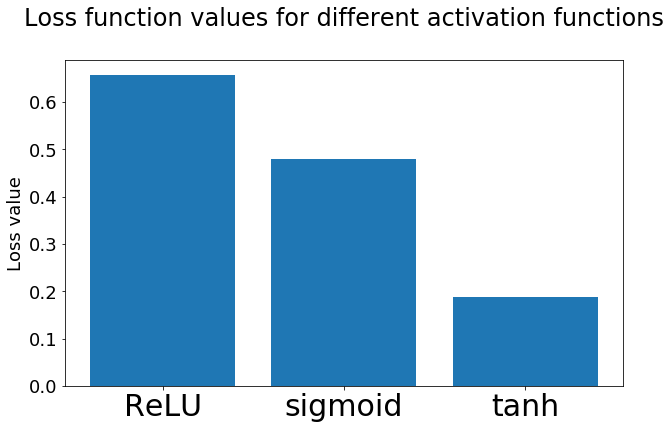

In [32]:
plt.figure(figsize=(10,6))
plt.bar(["ReLU", "sigmoid", "tanh"], results) 
plt.title("Loss function values for different activation functions\n", fontsize=24)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

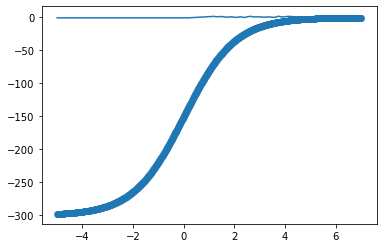

In [33]:
model = models[np.argmin(MSEs)]
model.scatter_regression(test_target, test_data)

### Cube

In [34]:
data, target, test_data, test_target = load_cube()
hidden_layers = [5,5]
results = []
models = []
activation_functions = [Activation.RELU, Activation.SIGMOID, Activation.TANH]
for i, activation_function in enumerate(activation_functions):
    MSEs = []
    for random_seed in range(2):
        loss_values, loss_test_values, model = testdata_MLP_regression(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[activation_function]*len(hidden_layers) + [Activation.LINEAR],
                        loss_function=MSE,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        MSEs.append(loss_test_values[-1])
        models.append(model)
    results.append(np.mean(MSEs))

100%|██████████| 1000/1000 [00:01<00:00, 545.61it/s]


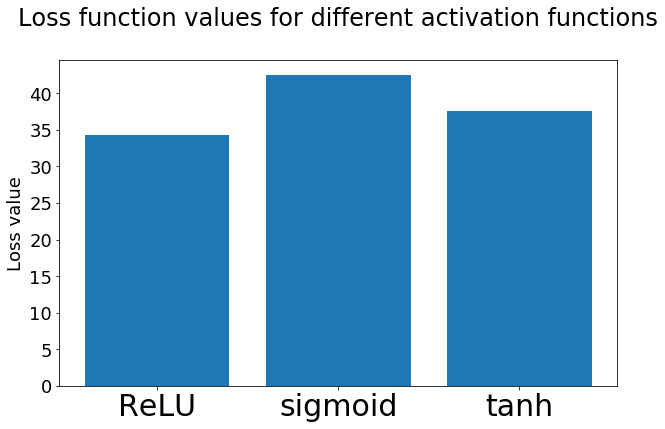

In [35]:
plt.figure(figsize=(10,6))
plt.bar(["ReLU", "sigmoid", "tanh"], results) 
plt.title("Loss function values for different activation functions\n", fontsize=24)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

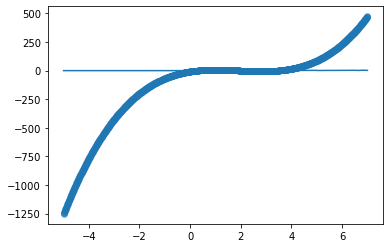

In [36]:
model = models[np.argmin(MSEs)]
model.scatter_regression(test_target, test_data)

## Classification

### Simple

In [37]:
data, target, test_data, test_target = load_simple()
hidden_layers = [5,5]
results = []
models = []
for i, activation_function in enumerate(activation_functions):
    CEs = []
    for random_seed in range(2):
        loss_values, loss_test_values, model = testdata_MLP_classification(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX],
                        loss_function=CROSSENTROPY,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        CEs.append(loss_test_values[-1])
        models.append(model)
    results.append(np.mean(CEs))

100%|██████████| 1000/1000 [00:01<00:00, 538.34it/s]


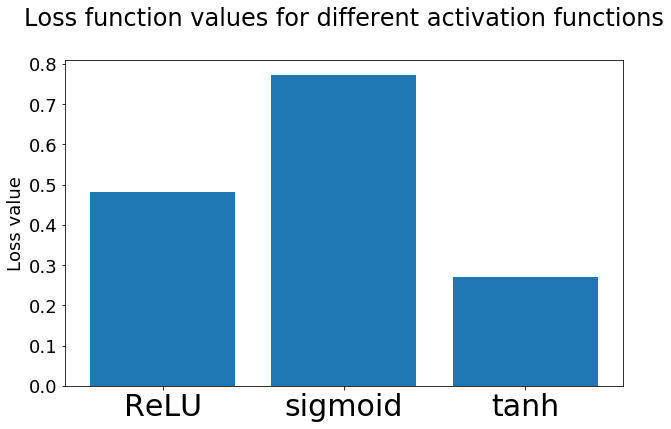

In [38]:
plt.figure(figsize=(10,6))
plt.bar(["ReLU", "sigmoid", "tanh"], results) 
plt.title("Loss function values for different activation functions\n", fontsize=24)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

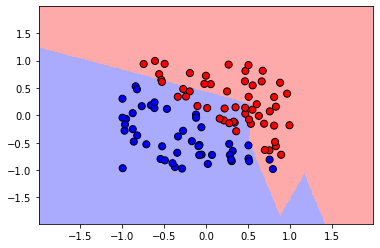

In [40]:
model = models[np.argmin(MSEs)]
model.scatter_classification(test_target, test_data)

### Three gauss

In [41]:
data, target, test_data, test_target = load_three_gauss()
hidden_layers = [5,5]
results = []
models = []
for i, activation_function in enumerate(activation_functions):
    CEs = []
    for random_seed in range(2):
        loss_values, loss_test_values, model = testdata_MLP_classification(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX],
                        loss_function=CROSSENTROPY,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        CEs.append(loss_test_values[-1])
        models.append(model)
    results.append(np.mean(CEs))

100%|██████████| 1000/1000 [00:04<00:00, 234.24it/s]


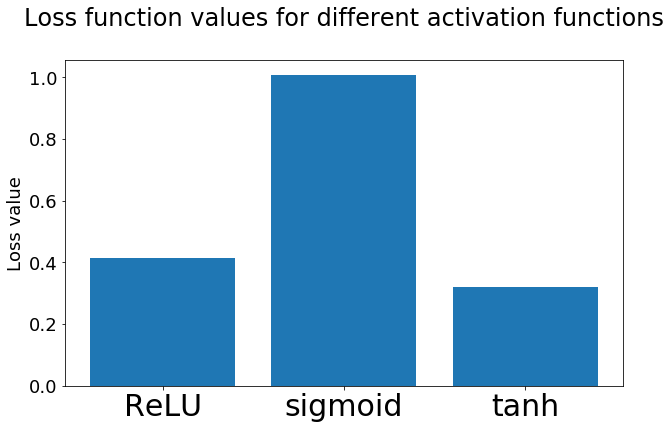

In [42]:
plt.figure(figsize=(10,6))
plt.bar(["ReLU", "sigmoid", "tanh"], results) 
plt.title("Loss function values for different activation functions\n", fontsize=24)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

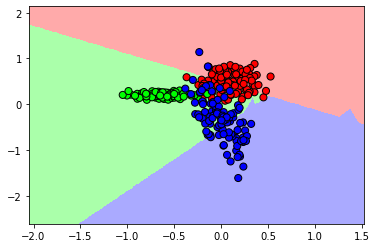

In [43]:
model = models[np.argmin(MSEs)]
model.scatter_classification(test_target, test_data)

100%|██████████| 1000/1000 [00:04<00:00, 231.27it/s]


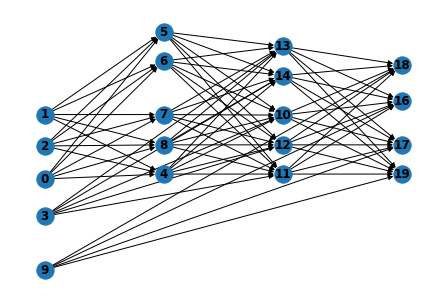

/Users/siemashko/Public/Studia/DataScienceMSc/Deep-Learning/DL-Project-1/MLP/__init__.py:179: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,


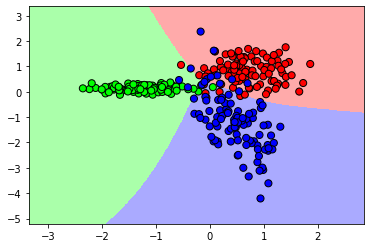

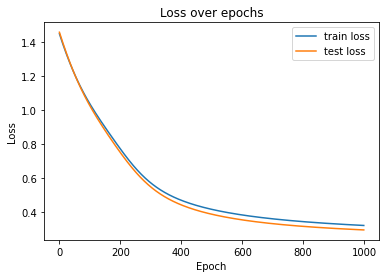

In [13]:
_ = testdata_MLP_classification(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.SOFTMAX],
                        loss_function=CROSSENTROPY,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=True)

# Architecture experiment

In [15]:
# Experiment search space
architectures = [[2,2], [5,5], [10,10], [5,10,5]]

## Regression

### Activation

In [16]:
data, target, test_data, test_target = load_activation()
results = []
for i, hidden_layers in enumerate(architectures):
    MSEs = []
    for random_seed in range(3):
        loss_values, loss_test_values, model = testdata_MLP_regression(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.LINEAR],
                        loss_function=MSE,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        MSEs.append(loss_test_values[-1])
    results.append(np.mean(MSEs))

100%|██████████| 1000/1000 [00:02<00:00, 400.60it/s]


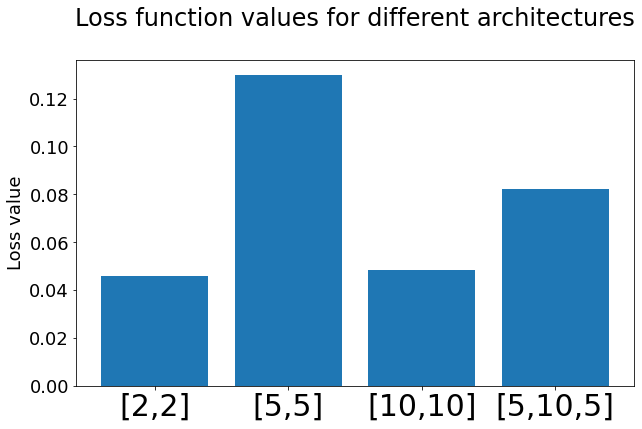

In [17]:
plt.figure(figsize=(10,6))
plt.bar(["[2,2]", "[5,5]", "[10,10]","[5,10,5]"], results) 
plt.title("Loss function values for different architectures\n", fontsize=24)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

### Cube

In [19]:
data, target, test_data, test_target = load_cube()
results = []
for i, hidden_layers in enumerate(architectures):
    MSEs = []
    for random_seed in range(3):
        loss_values, loss_test_values, model = testdata_MLP_regression(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.LINEAR],
                        loss_function=MSE,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        MSEs.append(loss_test_values[-1])
    results.append(np.mean(MSEs))

100%|██████████| 1000/1000 [00:14<00:00, 67.62it/s]


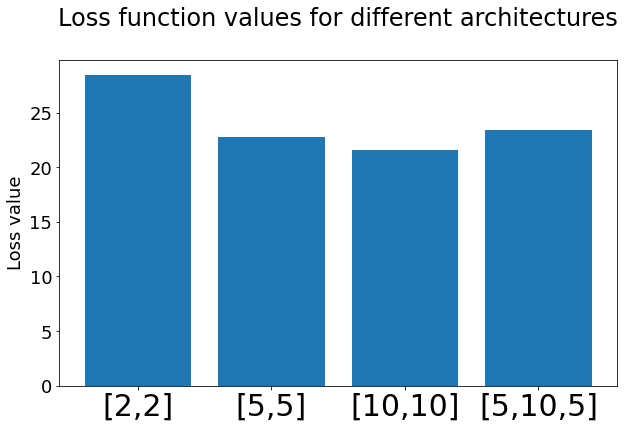

In [20]:
plt.figure(figsize=(10,6))
plt.bar(["[2,2]", "[5,5]", "[10,10]","[5,10,5]"], results) 
plt.title("Loss function values for different architectures\n", fontsize=24)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

## Classification

### Simple

In [21]:
data, target, test_data, test_target = load_simple()
results = []
for i, hidden_layers in enumerate(architectures):
    CEs = []
    for random_seed in range(3):
        loss_values, loss_test_values, model = testdata_MLP_classification(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.SOFTMAX],
                        loss_function=CROSSENTROPY,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        CEs.append(loss_test_values[-1])
    results.append(np.mean(CEs))

100%|██████████| 1000/1000 [00:02<00:00, 408.81it/s]


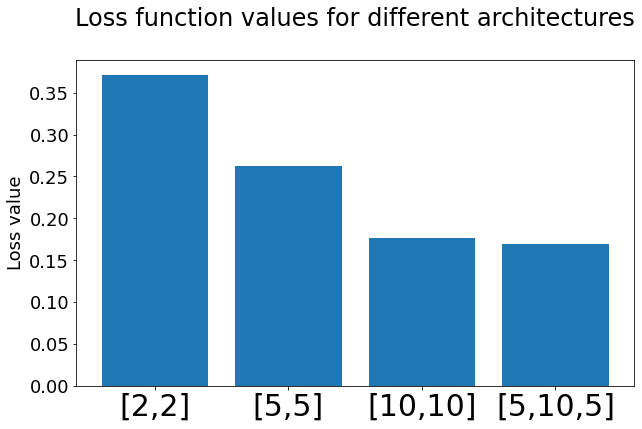

In [22]:
plt.figure(figsize=(10,6))
plt.bar(["[2,2]", "[5,5]", "[10,10]","[5,10,5]"], results) 
plt.title("Loss function values for different architectures\n", fontsize=24)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

### Three Gauss

In [25]:
data, target, test_data, test_target = load_three_gauss()
results = []
for i, hidden_layers in enumerate(architectures):
    CEs = []
    for random_seed in range(3):
        loss_values, loss_test_values, model = testdata_MLP_classification(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.SOFTMAX],
                        loss_function=CROSSENTROPY,
                        reg_L1=0,
                        reg_L2=0,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        CEs.append(loss_test_values[-1])
    results.append(np.mean(CEs))

100%|██████████| 1000/1000 [00:07<00:00, 125.48it/s]


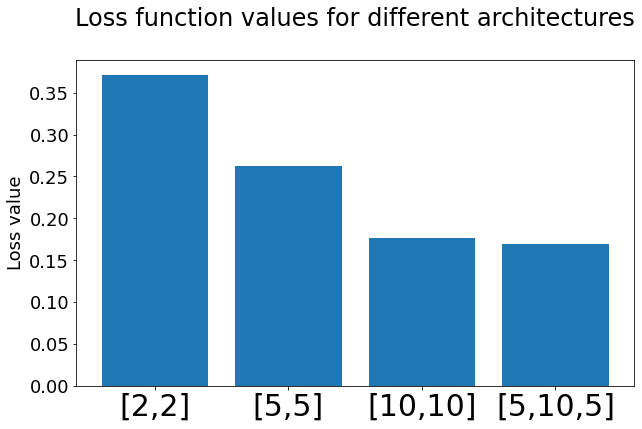

In [24]:
plt.figure(figsize=(10,6))
plt.bar(["[2,2]", "[5,5]", "[10,10]","[5,10,5]"], results) 
plt.title("Loss function values for different architectures\n", fontsize=24)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

# Loss function experiment

In [29]:
# Experiment search space
reg_values = [(0,0), (1e-2, 0), (1e-4, 0), (0, 1e-2), (0, 1e-4)]

## Regression

### Activation

In [30]:
data, target, test_data, test_target = load_activation()
hidden_layers = [10,10]
results = []
for i, (reg_L1, reg_L2) in enumerate(reg_values):
    MSEs = []
    for random_seed in range(3):
        loss_values, loss_test_values, model = testdata_MLP_regression(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.LINEAR],
                        loss_function=MSE,
                        reg_L1=reg_L1,
                        reg_L2=reg_L2,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        MSEs.append(loss_test_values[-1])
    results.append(np.mean(MSEs))

100%|██████████| 1000/1000 [00:03<00:00, 329.42it/s]


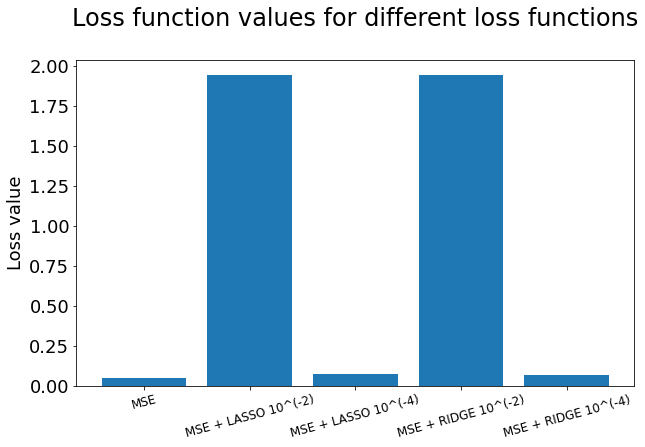

In [36]:
plt.figure(figsize=(10,6))
plt.bar(["MSE", "MSE + LASSO 10^(-2)", "MSE + LASSO 10^(-4)","MSE + RIDGE 10^(-2)","MSE + RIDGE 10^(-4)"], results) 
plt.title("Loss function values for different loss functions\n", fontsize=24)
plt.xticks(fontsize = 12, rotation = 15)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

### Cube

In [37]:
data, target, test_data, test_target = load_cube()
hidden_layers = [10,10]
results = []
for i, (reg_L1, reg_L2) in enumerate(reg_values):
    MSEs = []
    for random_seed in range(3):
        loss_values, loss_test_values, model = testdata_MLP_regression(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.LINEAR],
                        loss_function=MSE,
                        reg_L1=reg_L1,
                        reg_L2=reg_L2,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        MSEs.append(loss_test_values[-1])
    results.append(np.mean(MSEs))

100%|██████████| 1000/1000 [00:16<00:00, 60.89it/s]


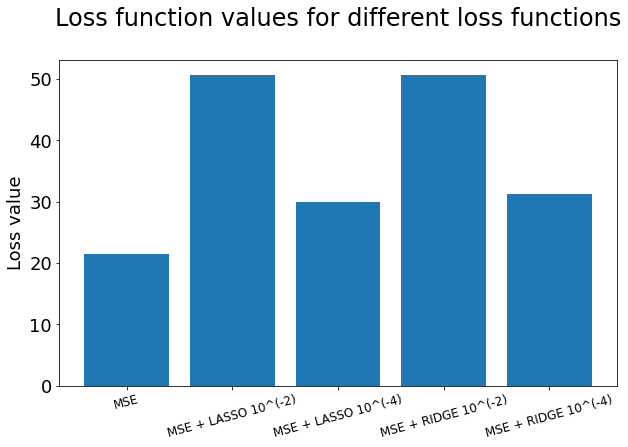

In [38]:
plt.figure(figsize=(10,6))
plt.bar(["MSE", "MSE + LASSO 10^(-2)", "MSE + LASSO 10^(-4)","MSE + RIDGE 10^(-2)","MSE + RIDGE 10^(-4)"], results) 
plt.title("Loss function values for different loss functions\n", fontsize=24)
plt.xticks(fontsize = 12, rotation = 15)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

## Classification

### Simple

In [41]:
data, target, test_data, test_target = load_simple()
hidden_layers = [10,10]
results = []
for i, (reg_L1, reg_L2) in enumerate(reg_values):
    CEs = []
    for random_seed in range(3):
        loss_values, loss_test_values, model = testdata_MLP_classification(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.SOFTMAX],
                        loss_function=CROSSENTROPY,
                        reg_L1=reg_L1,
                        reg_L2=reg_L2,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        CEs.append(loss_test_values[-1])
    results.append(np.mean(CEs))

100%|██████████| 1000/1000 [00:14<00:00, 69.38it/s]


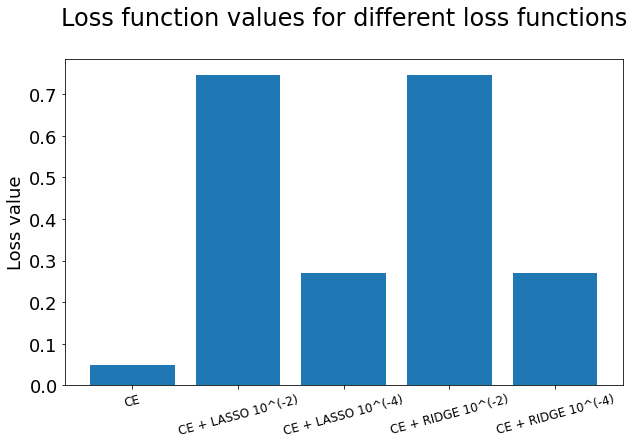

In [42]:
plt.figure(figsize=(10,6))
plt.bar(["CE", "CE + LASSO 10^(-2)", "CE + LASSO 10^(-4)","CE + RIDGE 10^(-2)","CE + RIDGE 10^(-4)"], results) 
plt.title("Loss function values for different loss functions\n", fontsize=24)
plt.xticks(fontsize = 12, rotation = 15)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()

### Three Gauss

In [43]:
data, target, test_data, test_target = load_three_gauss()
hidden_layers = [10,10]
results = []
for i, (reg_L1, reg_L2) in enumerate(reg_values):
    CEs = []
    for random_seed in range(3):
        loss_values, loss_test_values, model = testdata_MLP_classification(data=data,
                        y_train=target,
                        test=test_data,
                        y_test=test_target,
                        hidden_layers=hidden_layers,
                        weight_initialization=WeightInitialization.HE,
                        random_seed=random_seed,
                        activation_functions=[Activation.TANH]*len(hidden_layers) + [Activation.SOFTMAX],
                        loss_function=CROSSENTROPY,
                        reg_L1=reg_L1,
                        reg_L2=reg_L2,
                        batch_size=30,
                        epochs=1000,
                        learning_rate=1e-4,
                        momentum=0.9,
                        show_plots=False)
        CEs.append(loss_test_values[-1])
    results.append(np.mean(CEs))

 89%|████████▊ | 887/1000 [00:48<00:06, 18.36it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(["CE", "CE + LASSO 10^(-2)", "CE + LASSO 10^(-4)","CE + RIDGE 10^(-2)","CE + RIDGE 10^(-4)"], results) 
plt.title("Loss function values for different loss functions\n", fontsize=24)
plt.xticks(fontsize = 12, rotation = 15)
plt.yticks(fontsize = 18)
plt.ylabel("Loss value", fontsize = 18)
plt.show()